In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import shutil
import lmdb
import io
import tkinter as tk
from tkinter import *
from deslant_img import deslant_img
from tkinter import simpledialog, messagebox
from tkinter import ttk, IntVar, LEFT, RIGHT, TOP, BOTTOM, BOTH
from PIL import Image, ImageTk, UnidentifiedImageError

In [26]:
def rotacionar_imagem(imagem, angulo):
    altura, largura = imagem.shape[:2]
    ponto_central = (largura // 2, altura // 2)
    
    matriz_rotacao = cv2.getRotationMatrix2D(ponto_central, angulo, 1.0)
    
    cos = np.abs(matriz_rotacao[0, 0])
    sen = np.abs(matriz_rotacao[0, 1])
    
    nova_largura = int((altura * sen) + (largura * cos))
    nova_altura = int((altura * cos) + (largura * sen))
    
    matriz_rotacao[0, 2] += (nova_largura / 2) - ponto_central[0]
    matriz_rotacao[1, 2] += (nova_altura / 2) - ponto_central[1]

    imagem_rotacionada = cv2.warpAffine(imagem, matriz_rotacao, (nova_largura, nova_altura),
                                        flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_CONSTANT, borderValue=(255))
    return imagem_rotacionada

def adicionar_linhas_overlay(imagem, color=(128, 128, 128), transparencia=0.5):
    overlay = imagem.copy()
    altura = imagem.shape[0]
    espaco_entre_linhas = altura // 15
    for y in range(espaco_entre_linhas, altura, espaco_entre_linhas):
        cv2.line(overlay, (0, y), (imagem.shape[1], y), color, 2)
    cv2.addWeighted(overlay, transparencia, imagem, 1 - transparencia, 0, imagem)
    return imagem

def ajustar_rotacao(imagem):
    root = tk.Tk()
    root.title("Ajuste de Rotação da Imagem")

    angulo = IntVar(value=0)
    confirmado = False

    def atualizar_imagem():
        nonlocal img_tk
        rotacionada = rotacionar_imagem(imagem, angulo.get())
        rotacionada_com_overlay = adicionar_linhas_overlay(rotacionada.copy())
        image_rotated = Image.fromarray(cv2.cvtColor(rotacionada_com_overlay, cv2.COLOR_BGR2RGB))
        img_tk = ImageTk.PhotoImage(image=image_rotated)
        canvas.itemconfig(image_id, image=img_tk)
        canvas.config(scrollregion=canvas.bbox(tk.ALL))

    def aumentar_angulo():
        angulo.set(angulo.get() + 1)
        atualizar_imagem()

    def diminuir_angulo():
        angulo.set(angulo.get() - 1)
        atualizar_imagem()

    def confirmar():
        nonlocal confirmado
        confirmado = True
        root.quit()
        root.destroy()

    frame_principal = ttk.Frame(root)
    frame_principal.pack(fill=BOTH, expand=True)

    canvas = tk.Canvas(frame_principal)
    canvas.pack(side=LEFT, fill=BOTH, expand=True)

    v_scrollbar = ttk.Scrollbar(frame_principal, orient=tk.VERTICAL, command=canvas.yview)
    v_scrollbar.pack(side=RIGHT, fill=tk.Y)
    h_scrollbar = ttk.Scrollbar(root, orient=tk.HORIZONTAL, command=canvas.xview)
    h_scrollbar.pack(side=BOTTOM, fill=tk.X)

    canvas.configure(yscrollcommand=v_scrollbar.set, xscrollcommand=h_scrollbar.set)

    image = Image.fromarray(cv2.cvtColor(imagem, cv2.COLOR_GRAY2RGB))
    img_tk = ImageTk.PhotoImage(image=image)
    image_id = canvas.create_image(0, 0, anchor="nw", image=img_tk)
    canvas.config(scrollregion=canvas.bbox(tk.ALL))

    frame_botoes = ttk.Frame(root)
    frame_botoes.pack(side=BOTTOM, pady=10)

    btn_diminuir = ttk.Button(frame_botoes, text="-1 Grau", command=diminuir_angulo)
    btn_diminuir.pack(side=LEFT, padx=5)
    btn_aumentar = ttk.Button(frame_botoes, text="+1 Grau", command=aumentar_angulo)
    btn_aumentar.pack(side=LEFT, padx=5)
    btn_confirmar = ttk.Button(frame_botoes, text="Confirmar", command=confirmar)
    btn_confirmar.pack(side=LEFT, padx=5)

    root.protocol("WM_DELETE_WINDOW", confirmar)
    root.mainloop()

    if confirmado:
        return angulo.get()
    else:
        return None

In [27]:
def preprocessamento_e_thresholding(path_imagem):
    # Carregar imagem
    imagem = cv2.imread(path_imagem)
    img = cv2.fastNlMeansDenoisingColored(imagem, None, 5, 5, 7, 21)
    cv2.imshow('noise removal', img)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(72, 256))
    equalized = clahe.apply(gray)
    imagem_denoised_post = cv2.fastNlMeansDenoising(equalized, None, 20, 3, 50)

    # Aplicar thresholding adaptativo
    binarizada = imagem_denoised_post

    # Definir a largura da borda que você deseja eliminar
    borda = 5  # Isso define uma borda de 10 pixels
    color = 255

    # Eliminar ruídos nas bordas definindo os pixels para preto
    binarizada[:borda, :] = color  # Superior
    binarizada[-borda:, :] = color  # Inferior
    binarizada[:, :borda] = color  # Esquerda
    binarizada[:, -borda:] = color  # Direita

    angulo = ajustar_rotacao(binarizada)

    rotacionada = rotacionar_imagem(binarizada, angulo)
    # result = cv2.fastNlMeansDenoising(rotacionada, None, 20, 3, 50)

    # Visualizar o resultado do thresholding e remoção de ruído
    cv2.imshow('original', imagem)
    # cv2.imshow('result', result)
    cv2.imshow('Thresholding Adaptativo', binarizada)
    cv2.imshow('Rotacao', rotacionada)
    # cv2.imshow('Thresholding Adaptativo 2', binarizada2)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    # Opcional: Retornar a imagem processada para uso posterior
    return rotacionada

In [28]:
def filtrar_linhas_sem_texto(linhas_segmentadas, limiar_densidade=500):
    linhas_com_texto = []
    for linha in linhas_segmentadas:
        # Calcular a densidade de pixels da linha
        densidade_pixels = np.count_nonzero(linha)
        # print(densidade_pixels)
        # Verificar se a linha contém texto com base no limiar de densidade
        if densidade_pixels > limiar_densidade:
            linhas_com_texto.append(linha)
    return linhas_com_texto

def adicionar_borda_preta(imagem, top=15, bottom=15, left=10, right=10):
    """
    Adiciona uma borda preta ao redor da imagem.
    
    :param imagem: Imagem binarizada e invertida (texto branco, fundo preto).
    :param top: Espessura da borda superior.
    :param bottom: Espessura da borda inferior.
    :param left: Espessura da borda esquerda.
    :param right: Espessura da borda direita.
    :return: Imagem com borda preta adicionada.
    """
    borda_preta = cv2.copyMakeBorder(imagem, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    return borda_preta


def limpar_ruidos(linha, kernel_size=(5,5)):
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size)
    linha_limpa = cv2.morphologyEx(linha, cv2.MORPH_OPEN, kernel)
    return linha_limpa

In [29]:
def remover_ruido_por_densidade(img_binaria, limiar_densidade=10, altura_limite=0.1):
    # Criar uma cópia da imagem binarizada
    img_sem_ruido = img_binaria.copy()

    # Altura da imagem
    altura = img_binaria.shape[0]

    # Limites para considerar regiões próximas das bordas
    limite_superior = altura * altura_limite
    limite_inferior = altura * (1 - altura_limite)

    # Encontrar os componentes conectados na imagem binarizada
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(img_binaria, connectivity=8)

    # Determinar o componente principal (maior componente excluindo o fundo)
    principal_component_label = np.argmax(stats[1:, cv2.CC_STAT_AREA]) + 1

    # Iterar sobre os componentes conectados
    for label in range(1, num_labels):  # Começa em 1 para ignorar o componente de fundo
        if label == principal_component_label:
            continue  # Ignorar o componente principal

        # A área do componente
        area = stats[label, cv2.CC_STAT_AREA]

        # Posição y do componente
        y_position = centroids[label][1]

        # Condição adicional para verificar se está próximo das bordas superior ou inferior
        if y_position < limite_superior or y_position > limite_inferior:
            densidade = np.count_nonzero(labels == label)
            if densidade < limiar_densidade or area < limiar_densidade:
                img_sem_ruido[labels == label] = 0
        else:
            # Em regiões centrais, ser mais permissivo com a remoção
            if area < limiar_densidade:
                img_sem_ruido[labels == label] = 0

    return img_sem_ruido

In [30]:
def extrair_linhas_com_margem(img_path, margem_inicio, margem_fim, threshold, limiar_projecao):
    # Binarizar a imagem
    binarizada = preprocessamento_e_thresholding(img_path)

    # Projeção horizontal para identificar linhas
    projecao_horizontal = np.sum(255 - binarizada, axis=1)

    # Identificação de linhas baseada na projeção
    linhas = []
    em_linha = False
    for i, valor in enumerate(projecao_horizontal):
        if valor >= threshold and not em_linha:
            # Início de uma nova linha de texto
            inicio_linha = i
            em_linha = True
        elif valor < threshold and em_linha:
            # Final de uma linha de texto
            fim_linha = i
            # Ajustar o corte tanto no início quanto no final da linha
            ajustado_inicio_linha = max(0, inicio_linha - margem_inicio)  # Evita índice negativo
            ajustado_fim_linha = min(len(projecao_horizontal), fim_linha + margem_fim)  # Evita índice maior que a altura da imagem
            # Verificar se o valor da projeção horizontal excede o limiar durante a segmentação da linha
            if np.any(projecao_horizontal[ajustado_inicio_linha:ajustado_fim_linha] > limiar_projecao):
                # Se o limiar for excedido, descartar a segmentação atual e continuar para a próxima linha
                em_linha = False
                continue
            linhas.append((ajustado_inicio_linha, ajustado_fim_linha))
            em_linha = False

    # Para garantir que a última linha seja adicionada
    if em_linha:
        ajustado_fim_linha = min(len(projecao_horizontal), i + margem_fim)
        linhas.append((ajustado_inicio_linha, ajustado_fim_linha))

    # Segmentar a imagem em linhas individuais
    linhas_segmentadas = [binarizada[linha[0]:linha[1], :] for linha in linhas]

    # linhas_filtradas = filtrar_linhas_sem_texto(linhas_segmentadas)

    linhas_sem_angulacao = []

    # Mostrar as linhas segmentadas
    for idx, linha in enumerate(linhas_segmentadas):
        # linha = remover_ruido_por_densidade(linha)
        res = deslant_img(linha, 'grid', -2, 2, 20, 255)
        linhas_sem_angulacao.append(res.img)
        plt.figure(figsize=(10, 1))
        plt.imshow(res.img, cmap='gray', vmin=0, vmax=255)
        plt.title('Deslanted')
        plt.figure(figsize=(10, 1))
        plt.imshow(linha, cmap='gray')
        plt.title(f'Linha {idx + 1}')
        plt.show()

    # Visualizar a projeção horizontal
    # plt.plot(projecao_horizontal)
    # plt.xlabel('Linha')
    # plt.ylabel('Soma de Pixels')
    # plt.title('Projeção Horizontal')
    # plt.show()

    # palavras_das_linhas = segmentar_linhas_em_palavras(linhas_sem_angulacao)

    # Visualizar as palavras segmentadas de uma linha específica
    # for i, linha in enumerate(palavras_das_linhas[3]):  # Visualizar palavras da primeira linha segmentada
    #     plt.figure(figsize=(2, 2))
    #     plt.imshow(linha, cmap='gray')
    #     plt.title(f'Palavra {i + 1}')
    #     plt.show()

    return linhas_sem_angulacao

# extrair_linhas_com_margem("original_imgs/processed/texto1_pagina1.png", margem_inicio=13, margem_fim=13, threshold=8000, limiar_projecao=70000)

In [31]:
def resize_images(images, target_size):
    resized_images = []
    for img in images:
        # Redimensiona a imagem para o tamanho alvo usando o método de interpolação cv2.INTER_AREA
        resized_img = cv2.resize(img, target_size, interpolation=cv2.INTER_LANCZOS4)
        resized_images.append(resized_img)
    return resized_images

In [32]:
def save_line_images(image_filename, line_images, base_dir):
    # Extraia o número do texto e da página usando expressão regular
    match = re.match(r"texto(\d+)_pagina(\d+)\.png", image_filename)
    if not match:
        raise ValueError("Nome do arquivo não segue o formato 'textoX_paginaY.png'")

    text_num, page_num = match.groups()

    # Certifique-se de que o diretório base existe
    os.makedirs(base_dir, exist_ok=True)

    # Caminho do diretório para esta página específica dentro do texto
    page_dir = os.path.join(base_dir, f'texto{text_num}_pagina{page_num}')
    os.makedirs(page_dir, exist_ok=True)

    # Salvar cada linha da página com numeração única
    for line_index, line_img in enumerate(line_images):
        filename = f'texto{text_num}_pagina{page_num}_linha{line_index:04d}.png'
        filepath = os.path.join(page_dir, filename)
        cv2.imwrite(filepath, line_img)

    print(f"Images for text {text_num} page {page_num} saved in {page_dir}")

def review_images_in_directory(directory):
    def load_images():
        # Carrega todas as imagens PNG em ordem numérica baseada no nome
        files = [file for file in os.listdir(directory) if file.endswith('.png')]
        return sorted(files, key=lambda x: int(re.findall(r"linha(\d+)\.png", x)[0]))

    def update_image(img_path):
        img = Image.open(img_path)
        photo = ImageTk.PhotoImage(img)
        image_label.config(image=photo)
        image_label.image = photo

    def keep_image():
        nonlocal index
        kept_files.append(image_files[index])
        index += 1
        if index < len(image_files):
            update_image(os.path.join(directory, image_files[index]))
        else:
            root.quit()

    def discard_image():
        nonlocal index
        os.remove(os.path.join(directory, image_files[index]))
        index += 1
        if index < len(image_files):
            update_image(os.path.join(directory, image_files[index]))
        else:
            root.quit()

    image_files = load_images()
    kept_files = []
    index = 0

    if image_files:
        root = Tk()
        root.title("Image Reviewer")
        image_label = Label(root)
        image_label.pack()
        btn_keep = Button(root, text="Keep", command=keep_image)
        btn_keep.pack(side="left", expand=True)
        btn_discard = Button(root, text="Discard", command=discard_image)
        btn_discard.pack(side="right", expand=True)
        update_image(os.path.join(directory, image_files[index]))
        root.mainloop()
    
    root.destroy()
    return kept_files  # Retorna lista de imagens mantidas

def renumber_images(directory, kept_files):
    # Verificar se a lista de arquivos mantidos está vazia
    if not kept_files:
        print("Nenhuma imagem para renomear.")
        return

    # Extrair o número do texto e da página do nome do diretório usando expressão regular
    match = re.search(r"texto(\d+)_pagina(\d+)", directory)
    if not match:
        raise ValueError("O diretório não segue o formato 'textoX_paginaY'")

    text_num, page_num = match.groups()

    # Verificar se a sequência numérica dos 4 últimos dígitos dos nomes das imagens está correta
    expected_index = 0
    need_renaming = False
    for file in kept_files:
        index_match = re.search(r"(\d{4})\.png$", file)
        if index_match:
            actual_index = int(index_match.group(1))
            if actual_index != expected_index:
                need_renaming = True
                break
            expected_index += 1

    # Renomear arquivos mantidos, se necessário
    if need_renaming:
        for index, file in enumerate(kept_files, start=0):
            old_path = os.path.join(directory, file)
            new_filename = f'texto{text_num}_pagina{page_num}_linha{index:04d}.png'
            new_path = os.path.join(directory, new_filename)

            # Renomeia o arquivo
            os.rename(old_path, new_path)

        print("Imagens renomeadas com sucesso.")
    else:
        print("A numeração das imagens está correta. Nenhuma renomeação necessária.")

In [33]:
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [atoi(c) for c in re.split(r'(\d+)', text)]

def process_images(original_path, processed_path, threshold):
    # Garantir que o diretório de saída existe
    os.makedirs(processed_path, exist_ok=True)

    # Percorrer todas as imagens no caminho original, ordenadas naturalmente
    filenames = sorted(os.listdir(original_path), key=natural_keys)
    print("--------------Iniciando pré-processamento das imagens--------------\n")
    for filename in filenames:
        if filename.endswith('.png'):
            print(filename)
            # Extrair linhas com margem
            vetor_de_linhas = extrair_linhas_com_margem(os.path.join(original_path, filename), margem_inicio=13, margem_fim=13, threshold=threshold, limiar_projecao=80000)

            # Redimensionar imagens
            vetor_de_linhas = resize_images(vetor_de_linhas, (800, 50))

            # Salvar as linhas das imagens
            save_line_images(filename, vetor_de_linhas, processed_path)

            # Revisar e renomear as imagens
            page_dir = os.path.join(processed_path, os.path.splitext(filename)[0])
            kept_files = review_images_in_directory(page_dir)
            renumber_images(page_dir, kept_files)

            # Mover a imagem original para um subdiretório de imagens processadas
            processed_subdir = os.path.join(original_path, "processed")
            os.makedirs(processed_subdir, exist_ok=True)
            shutil.move(os.path.join(original_path, filename), processed_subdir)

            # Caminho completo para o arquivo .txt
            caminho_arquivo = os.path.join(original_path, "ultima_imagem_processada.txt")
            
            # Salva o nome da última imagem processada no arquivo .txt
            with open(caminho_arquivo, "w") as arquivo_txt:
                arquivo_txt.write(filename)

            print("--------------Próxima página--------------\n")
            break

texto33_pagina2.png


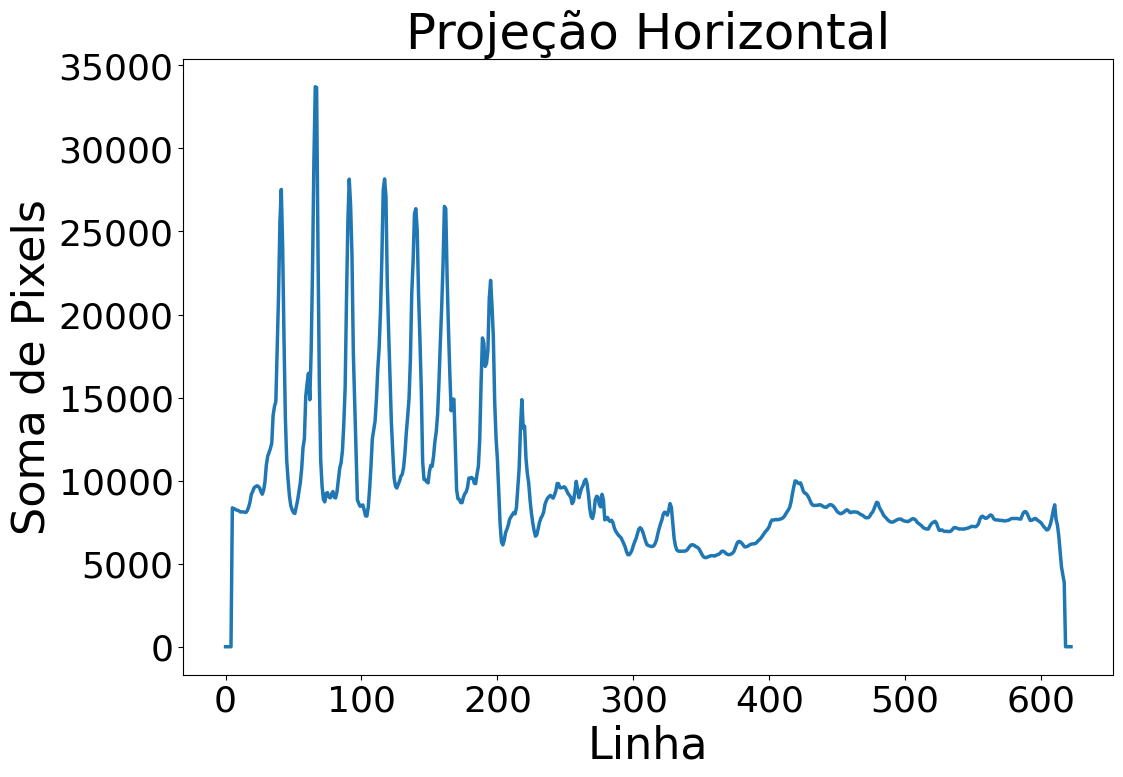

In [63]:
filenames = sorted(os.listdir("original_imgs/"), key=natural_keys)
for filename in filenames:
    if filename.endswith('.png'):
        print(filename)
        binarizada = preprocessamento_e_thresholding(os.path.join("original_imgs/", filename))

        # Projeção horizontal para identificar linhas
        projecao_horizontal = np.sum(255 - binarizada, axis=1)

        # Visualizar a projeção horizontal com ajustes de escala e fontes
        plt.figure(figsize=(12, 8))  # Ajusta o tamanho da figura
        plt.plot(projecao_horizontal, linewidth=2.5)
        plt.xlabel('Linha', fontsize=32)  # Ajusta o tamanho da fonte do rótulo do eixo X
        plt.ylabel('Soma de Pixels', fontsize=32)  # Ajusta o tamanho da fonte do rótulo do eixo Y
        plt.title('Projeção Horizontal', fontsize=36)  # Ajusta o tamanho da fonte do título
        plt.xticks(fontsize=26)  # Ajusta o tamanho da fonte dos valores do eixo X
        plt.yticks(fontsize=26)  # Ajusta o tamanho da fonte dos valores do eixo Y
        plt.grid(False)  # Adiciona uma grade para melhor visualização
        plt.show()
        break

--------------Iniciando pré-processamento das imagens--------------

texto33_pagina2.png


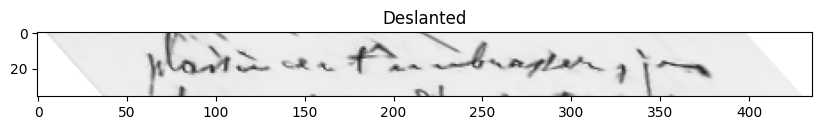

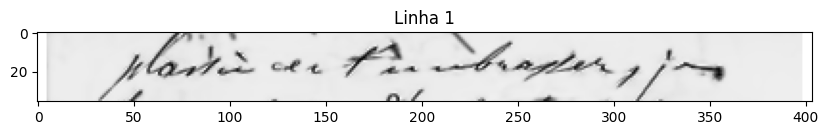

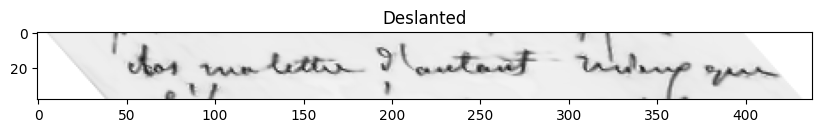

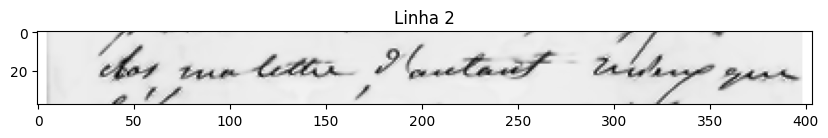

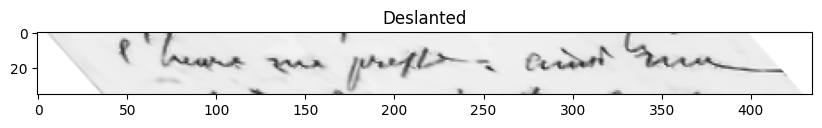

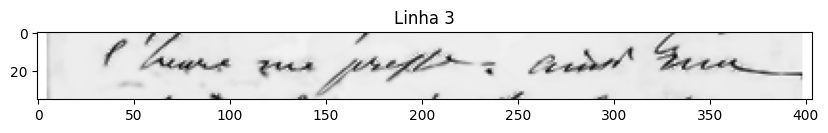

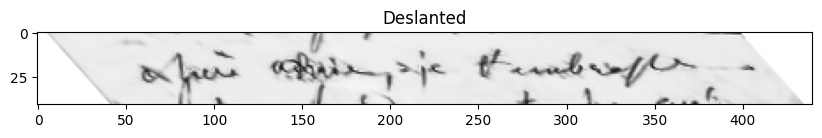

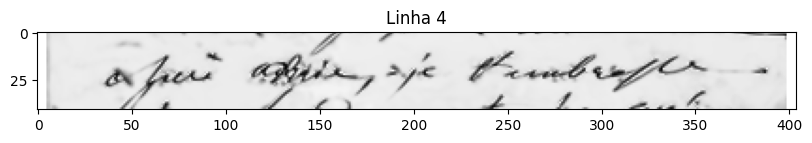

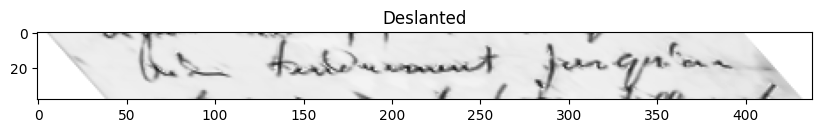

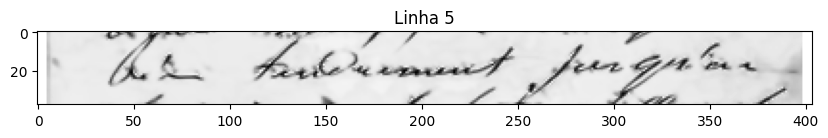

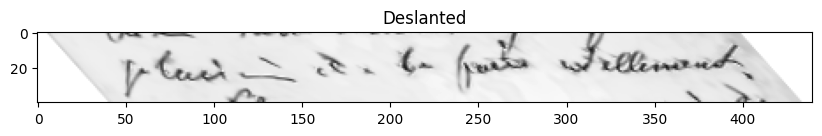

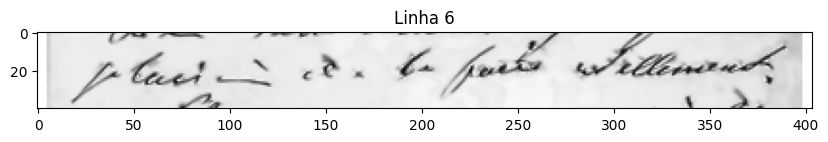

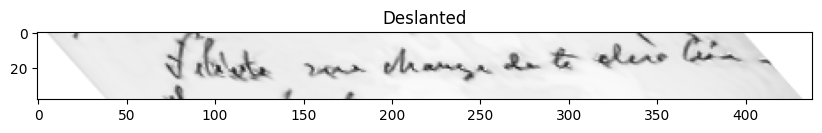

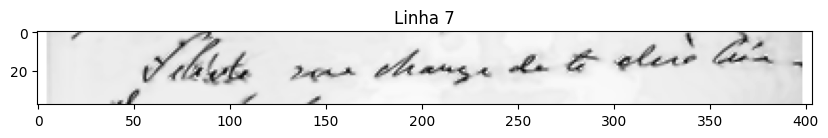

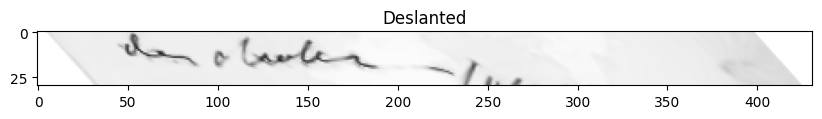

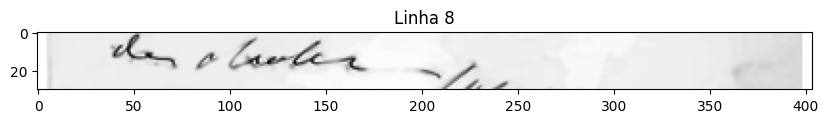

Images for text 33 page 2 saved in processed_imgs/texto33_pagina2
Imagens renomeadas com sucesso.
--------------Próxima página--------------



In [64]:

# vetor_de_linhas = extrair_linhas_com_margem("original_imgs/texto3_pagina1.png", margem_inicio=13, margem_fim=13, threshold=20000, limiar_projecao=70000)

process_images("original_imgs/", "processed_imgs/", threshold=12500)

In [13]:
def increment_line_numbers(directory):
    # Regex para encontrar arquivos com nomes no formato "texto23_pagina2_linhaX"
    pattern = re.compile(r"(.*_linha)(\d{4})(\..+)")
    
    # Listar todos os arquivos e ordená-los em ordem decrescente
    files = os.listdir(directory)
    files.sort(reverse=True)
    
    for filename in files:
        match = pattern.match(filename)
        if match:
            base = match.group(1)
            number = match.group(2)
            extension = match.group(3)
            
            # Incrementar o número em 1
            incremented_number = int(number) + 1
            # Formatar o número para 4 dígitos
            new_number = f"{incremented_number:04}"
            
            # Novo nome do arquivo
            new_filename = f"{base}{new_number}{extension}"
            
            # Caminhos completos para renomeação
            old_filepath = os.path.join(directory, filename)
            new_filepath = os.path.join(directory, new_filename)
            
            # Renomear o arquivo
            os.rename(old_filepath, new_filepath)
            print(f"Renamed: {filename} -> {new_filename}")

# Exemplo de uso
directory_path = 'texto32_pagina1'
increment_line_numbers(directory_path)

Renamed: texto32_pagina1_linha0020.png -> texto32_pagina1_linha0021.png
Renamed: texto32_pagina1_linha0019.png -> texto32_pagina1_linha0020.png
Renamed: texto32_pagina1_linha0018.png -> texto32_pagina1_linha0019.png
Renamed: texto32_pagina1_linha0017.png -> texto32_pagina1_linha0018.png
Renamed: texto32_pagina1_linha0016.png -> texto32_pagina1_linha0017.png
Renamed: texto32_pagina1_linha0015.png -> texto32_pagina1_linha0016.png
Renamed: texto32_pagina1_linha0014.png -> texto32_pagina1_linha0015.png
Renamed: texto32_pagina1_linha0013.png -> texto32_pagina1_linha0014.png
Renamed: texto32_pagina1_linha0012.png -> texto32_pagina1_linha0013.png
Renamed: texto32_pagina1_linha0011.png -> texto32_pagina1_linha0012.png
Renamed: texto32_pagina1_linha0010.png -> texto32_pagina1_linha0011.png
Renamed: texto32_pagina1_linha0009.png -> texto32_pagina1_linha0010.png
Renamed: texto32_pagina1_linha0008.png -> texto32_pagina1_linha0009.png
Renamed: texto32_pagina1_linha0007.png -> texto32_pagina1_linha0

In [1]:
def pad_folder_numbers(directory):
    # Regex para encontrar pastas com nomes no formato "textoX_paginaY"
    pattern = re.compile(r"(texto)(\d+)(_pagina)(\d+)")

    for folder_name in os.listdir(directory):
        folder_path = os.path.join(directory, folder_name)
        if os.path.isdir(folder_path):
            match = pattern.match(folder_name)
            if match:
                part1 = match.group(1)
                number1 = int(match.group(2))
                part2 = match.group(3)
                number2 = int(match.group(4))

                # Formatar os números para dois dígitos
                formatted_number1 = f"{number1:02}"
                formatted_number2 = f"{number2:02}"

                # Novo nome da pasta
                new_folder_name = f"{part1}{formatted_number1}{part2}{formatted_number2}"
                new_folder_path = os.path.join(directory, new_folder_name)

                # Renomear a pasta
                os.rename(folder_path, new_folder_path)
                print(f"Renamed: {folder_name} -> {new_folder_name}")

# Exemplo de uso
directory_path = 'consertar'
pad_folder_numbers(directory_path)

NameError: name 're' is not defined

In [173]:
def pad_image_numbers_in_folders(directory):
    # Regex para encontrar imagens com nomes no formato "textoX_paginaY_linhaZ.png"
    pattern = re.compile(r"(texto)(\d+)(_pagina)(\d+)(_linha\d{4}\.png)")

    for folder_name in os.listdir(directory):
        folder_path = os.path.join(directory, folder_name)
        if os.path.isdir(folder_path):
            for filename in os.listdir(folder_path):
                file_path = os.path.join(folder_path, filename)
                if os.path.isfile(file_path):
                    match = pattern.match(filename)
                    if match:
                        part1 = match.group(1)
                        number1 = int(match.group(2))
                        part2 = match.group(3)
                        number2 = int(match.group(4))
                        rest = match.group(5)

                        # Formatar os números para dois dígitos
                        formatted_number1 = f"{number1:02}"
                        formatted_number2 = f"{number2:02}"

                        # Novo nome do arquivo
                        new_filename = f"{part1}{formatted_number1}{part2}{formatted_number2}{rest}"
                        new_file_path = os.path.join(folder_path, new_filename)

                        # Renomear o arquivo
                        os.rename(file_path, new_file_path)
                        print(f"Renamed: {filename} -> {new_filename}")

# Exemplo de uso
directory_path = 'processed_imgs'
pad_image_numbers_in_folders(directory_path)

Renamed: texto1_pagina1_linha0000.png -> texto01_pagina01_linha0000.png
Renamed: texto1_pagina1_linha0001.png -> texto01_pagina01_linha0001.png
Renamed: texto1_pagina1_linha0002.png -> texto01_pagina01_linha0002.png
Renamed: texto1_pagina1_linha0003.png -> texto01_pagina01_linha0003.png
Renamed: texto1_pagina1_linha0004.png -> texto01_pagina01_linha0004.png
Renamed: texto1_pagina1_linha0005.png -> texto01_pagina01_linha0005.png
Renamed: texto1_pagina1_linha0006.png -> texto01_pagina01_linha0006.png
Renamed: texto1_pagina1_linha0007.png -> texto01_pagina01_linha0007.png
Renamed: texto1_pagina1_linha0008.png -> texto01_pagina01_linha0008.png
Renamed: texto1_pagina1_linha0009.png -> texto01_pagina01_linha0009.png
Renamed: texto1_pagina1_linha0010.png -> texto01_pagina01_linha0010.png
Renamed: texto1_pagina1_linha0011.png -> texto01_pagina01_linha0011.png
Renamed: texto1_pagina1_linha0012.png -> texto01_pagina01_linha0012.png
Renamed: texto1_pagina1_linha0013.png -> texto01_pagina01_linha0